In [33]:
from __future__ import print_function
import os
import sys
import time

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate
from torchvision import datasets, transforms

from model import Angle_Discriminator
device='cpu'
def rotate_tensor(input,angles,plot=False):
    """
    Args:
        input: [N,c,h,w] **numpy** tensor
        angles: [N,]    **numpy** tensor
    Returns:
        rotated output as torch tensor
    """
    outputs = []
    for i in range(input.shape[0]):
        output = rotate(input[i,...], 180*angles[i]/np.pi, axes=(1,2), reshape=False)
        outputs.append(output)
    outputs=np.stack(outputs, 0)
    if plot:
        #Create a grid plot with original and scaled images
        N=input.shape[0]
        rows=int(np.floor(N**0.5))
        cols=N//rows
        plt.figure()
        for j in range(N):
            plt.subplot(rows,cols,j+1)
            if input.shape[1]>1:
                image=input[j].transpose(1,2,0)
            else:
                image=input[j,0]

            plt.imshow(image, cmap='gray')
            plt.grid(False)
            plt.axis('off')
        #Create new figure with rotated
        plt.figure(figsize=(5,5))
        for j in range(N):
            plt.subplot(rows,cols,j+1)
            if input.shape[1]>1:
                image=outputs[j].transpose(1,2,0)
            else:
                image=outputs[j,0]
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.title(r'$\theta$={:.1f}'.format( angles[j]*180/np.pi), fontsize=6)
            plt.grid(False)
        plt.tight_layout()      
        plt.show()
    
    return torch.from_numpy(outputs)

### Load Model

In [34]:
model = Angle_Discriminator(device).to(device)
filepath='./model_reg/checkpoint.pt'
pretrained_dict = torch.load(filepath)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(pretrained_dict)

#Load test dataset
test_batch_size=12
kwargs={}
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor()
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

### Define function for inference

In [43]:
def get_angle(x,y):
    """
    Return the rotation angle between 2 feature vectors x and y
    
    Args:
    x: [D,1] **numpy** tensor
    y: [D,1] **numpy** tensor
    """
    sum=0.0
    for i in range(0,x.shape[0]-1,2):
        x_i=x[i:i+2]
        y_i=y[i:i+2]
        dot_prod=np.dot(x_i,y_i)
        x_norm=np.linalg.norm(x_i)
        y_norm=np.linalg.norm(y_i)
        import pdb;pdb.set_trace()
        sum+= dot_prod/(x_norm*y_norm)
    return sum/(x.shape[0]//2)

def test(model,test_loader):
    """
    Passes a rotated image through the bott
    """
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            #Get rotated vector
            angles = np.linspace(0,np.pi/2,test_loader.batch_size)
            target = rotate_tensor(data.numpy(),angles,plot=True)
            data=data.to(device)
            target=target.to(device)
            
            #Forward pass for data and targer
            angles_estimate=model(data,target)
            break
        angles_estimate=angles_estimate.cpu()
    return (angles*180/np.pi), angles_estimate
    
#     #Get the rotation angle from the embedding
#     angles_estimate=np.zeros_like(angles)
#     for i in range(test_loader.batch_size):
#         angles_estimate[i]=get_angle(data_fvector[i], target_fvector[i])
#     angles_degrees=angles*180/np.pix
#     angles_est_degrees=angles_estimate*180/np.pi

#     return (angles_degrees,angles_est_degrees)        

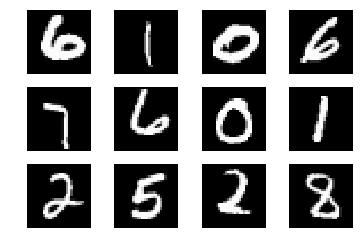

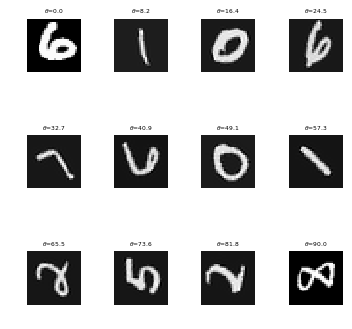

In [44]:
GT,estimate= test(model, test_loader)

In [45]:
GT


array([ 0.        ,  8.18181818, 16.36363636, 24.54545455, 32.72727273,
       40.90909091, 49.09090909, 57.27272727, 65.45454545, 73.63636364,
       81.81818182, 90.        ])

In [46]:
estimate

tensor([[  0.0000],
        [ 20.0842],
        [ 27.0354],
        [ 40.9545],
        [ 61.3336],
        [ 63.4800],
        [ 62.7996],
        [ 72.4513],
        [ 88.3440],
        [ 86.7773],
        [ 83.0943],
        [ 73.8485]])